# Geradores

## $ \pi^*$

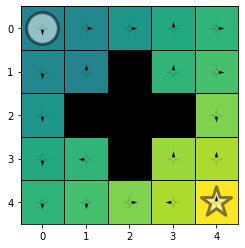

In [1]:
import numpy as np
from grid import Grid
from plot import plotPolicy, plotStateValue, plotActionStateValue, plotEffects, plotTrajectory

g = Grid()
g.pi_star(epsilon=.05)
# g.q_star()

ax = plotEffects(g)
plotPolicy(g.PI, g, ax=ax)
plotActionStateValue(g.Q, g, ax=ax)
# np.array([sum(q) for q in g.Q]).reshape(*g.size)
# g.PI
pi_star = g.PI

In [2]:
def generatePis(params=.05):
    h1 = Grid()
    target_1 = 4
    h1.effects[(4,4)] = {'noise': lambda a: [-a[0], -a[1]]}
    h1.effects[h1.S[target_1]] = {'terminal': True, 'reward': 10}
    h1.pi_star(epsilon=params)

    h2 = Grid()
    target_2 = 20
    h2.effects[(4,4)] = {'noise': lambda a: [-a[0], -a[1]]}
    h2.effects[h2.S[target_2]] = {'terminal': True, 'reward': 10}
    h2.pi_star(epsilon=params)
    
    return h1.PI, h2.PI

pi1, pi2 = generatePis()

## $ h_1 $ 


<AxesSubplot: >

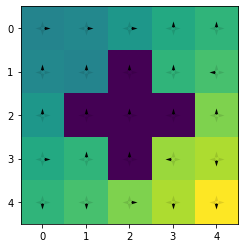

In [3]:
# ax = plotEffects(g)
ax = plotPolicy(pi1, g)
plotActionStateValue(g.Q, g, ax=ax)


## $ h_2 $ 

<AxesSubplot: >

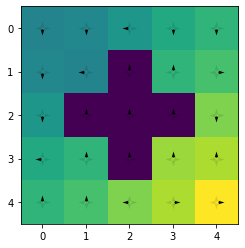

In [4]:
# ax = plotEffects(h2)
ax = plotPolicy(pi2, g)
plotActionStateValue(g.Q, g, ax=ax)


## $ \xi $

$ \eta(h|s) = \{^{.95 \;\; se \;\; s \in S^h}_{.05 \;\; se \;\; s \notin S^h} \;\; \forall h \in \mathcal{H} \; e \; \forall s \in S$ <br>
$ \pi_h(a|s) = \epsilon = 0.05 = \{^{.9625 \;\; se \;\; a = a^*}_{.0125 \;\; se \;\; a \ne a^*}  \;\; \forall a \in A \; e \; \forall s \in S$ <br>
$ \psi_h(s) = 0.3 \;\; \forall s \in S$

In [5]:
def generateTheta(param_eta=.95, param_pi=.05, param_psi=.3):    
    eta_s = {
                0: list(set(range(10, 25)) - {14}),
                1: list(range(10))+[14], 
            }
    psis = [[param_psi for _ in g.S]]*2
    pis = generatePis(param_pi)
    
    H = list(zip(pis, psis))
    eta = np.array([[param_eta if s in eta_s[h] else (1-param_eta) for h,_ in enumerate(H)] for s,_ in enumerate(g.S)])

    return H, eta
    
generateTheta()

([(array([[0.0125, 0.0125, 0.9625, 0.0125],
          [0.0125, 0.0125, 0.9625, 0.0125],
          [0.0125, 0.0125, 0.9625, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.0125, 0.0125, 0.0125, 0.9625],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.0125, 0.0125, 0.9625, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.9625, 0.0125, 0.0125, 0.0125],
          [0.0125, 0.0125, 0.0125, 0.9625],
          [0.0125, 0.9625, 0.0125, 0.0125],
          [0.0125, 0.9625, 0.0125, 0.0125],
          [0.0125, 0.9625, 0.0125, 0.0125],
          [0.0125, 0.0125, 0.962

<AxesSubplot: >

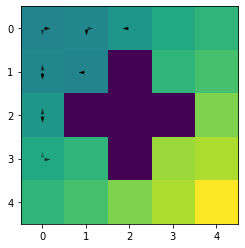

In [6]:
import random

def generateTrajetoryPi(pi, g, size=10):
    s = 0

    arr = []
    for _ in range(size-1):
        a  = random.choices(list(range(len(g.A))), pi[s], k=1)[0]
        step =  (s, a)
        s,_,_ = g.transition(s,  a)
        arr.append(step)
    arr.append((s, None))

    return arr

def generateTrajetory(H, eta, g, size=10):
    s = 0
    b = 1
    h = None
    arr = []
    for _ in range(size-1):
        if b == 1:
            h = random.choices(list(range(len(eta[s]))), eta[s], k=1)[0]
        
        pi, psi = H[h]
        
        a  = random.choices(list(range(len(pi[s]))), pi[s], k=1)[0]
        step =  (s, a)
        s,_,_ = g.transition(s,  a)
        arr.append(step)
        b = random.choices([0,1], [1-psi[s], psi[s]], k=1)[0]
    arr.append((s, None))

    return arr


H, eta = generateTheta()
E = generateTrajetory(H, eta, g, 15)
# E = generateTrajetoryPi(pi_star, g)

# ax = plotEffects(g)
# plotPolicy(h_2.PI, h_2, ax=ax)
ax = plotTrajectory(E, g)
plotActionStateValue(g.Q, g, ax=ax)

# Gradient Descent

In [7]:
from ddo import DDO 

def get_eg_from_theta(E, eta, pi, psi):
    H, eta = generateTheta(eta, pi, psi)
    ddo = DDO(E, H, eta)
    return ddo.expectation_gradient2()

get_eg_from_theta(E, .95, .05, .3)

array([ -2.59029303, -59.4751585 ,  -0.76870924])

In [8]:
import matplotlib.pyplot as plt

def plot_gradient_descent(opt, params):
    fig, axs = plt.subplots(1,3, figsize=(20,5))

    y = np.array([(x,y,z) for (x,y,z) in opt])
    n = len(y)
    x = range(n)

    print("Estimative: ", y[-1])

    for i, p in enumerate(params):
        axs[i].plot(x, y[:,i])
        axs[i].plot(range(n+5), [p for _ in range(n+5)], color='red', linestyle='dashed')
        axs[i].text(len(opt)+len(opt)*.05, p, f'true', color='red')
        axs[i].set_title(f'Theta[{i}]')
        axs[i].set_ylabel('value')
        axs[i].set_xlabel('trial')

In [9]:
import random 

def GradientDescent(Es, param=None, learning_rate=1e-6, max_trials=100, stochastic=True):
    if param is None:
        param = np.random.rand(3)
    for _ in range(max_trials):
        # print(f'param: {param}')
        if stochastic:
            param = param + learning_rate * get_eg_from_theta(random.choice(Es), *param)
        else:
            param = param + learning_rate * np.sum(np.array([get_eg_from_theta(E, *param) for E in Es]), axis=0)
        yield param

### Single Trajectory

[ 0.16215547 -3.8609005   0.53888321]
Estimative:  [ 0.16215547 -3.8609005   0.53888321]


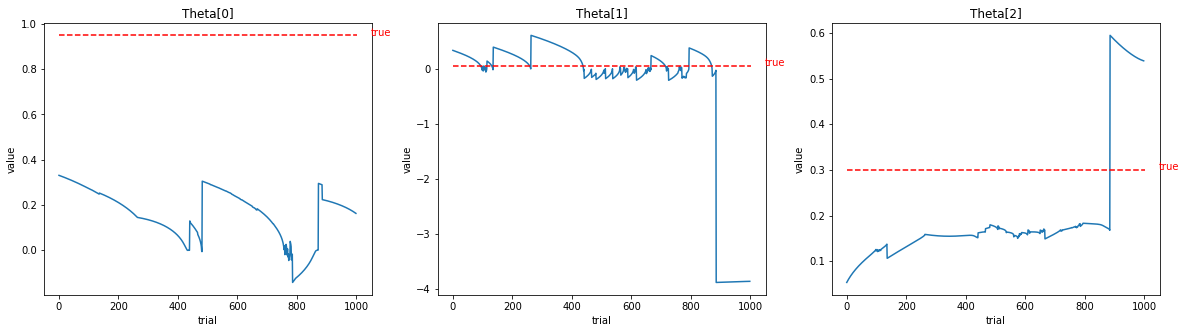

In [10]:
params = [.95, .05, .3]
H, eta = generateTheta(*params)
E = generateTrajetory(H, eta, g, 15)

opt = [i for i in  GradientDescent([E], learning_rate=1e-4, max_trials=1000)]

print(opt[-1])
plot_gradient_descent(opt, params)

### Multi Trajectory

### Stochastic

Estimative:  [ 0.48700978 -0.08360052  0.32496377]


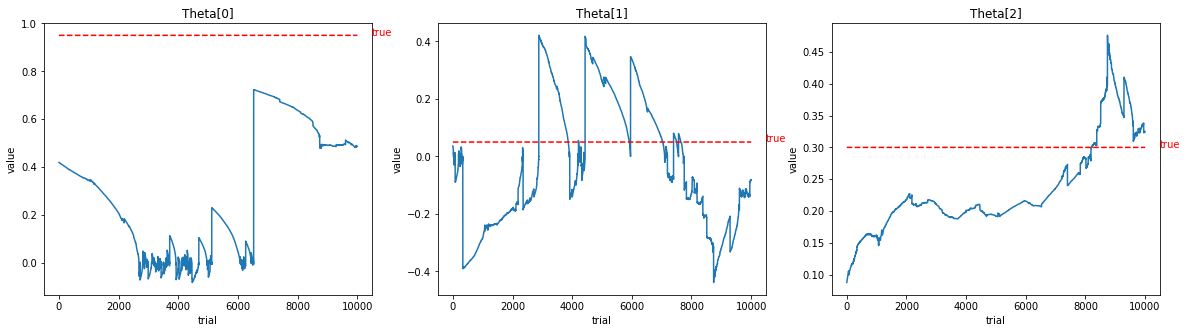

In [11]:
params = [.95, .05, .3]

n = 100
size_range = (10, 30)

Es = [generateTrajetory(*generateTheta(*params), g, random.randrange(*size_range)) for _ in range(n)] 

opt = [i for i in  GradientDescent(Es, learning_rate=1e-5, max_trials=10000)]
plot_gradient_descent(opt, params)

In [12]:
# params = [.95, .05, .3]

# n = 100
# size_range = (10, 20)

# Es = [generateTrajetory(*generateTheta(*params), g, random.randrange(*size_range)) for _ in range(n)] 

# opt = [i for i in  GradientDescent(Es, stochastic=False)]
# print('estimative: ', opt[-1])